In [1]:
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.engine import training
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras.models import Model
from keras import Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Average
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score
from scipy import stats
from statistics import mean
from keras.models import load_model
from keras.datasets import cifar10
import tensorflow as tf
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

In [2]:

# Load the MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

# Reshape the feature matrix to a 2D array
X_train_full = X_train_full.reshape((X_train_full.shape[0], -1))

# Set the number of samples for each set
num_train_samples = 10000
num_val_samples = 39000
num_test_samples = 39000

# Split the dataset into a training set and the rest
X_train, X_rest, y_train, y_rest = train_test_split(X_train_full, y_train_full, train_size=num_train_samples, random_state=42)

# Split the remaining data into a validation set and a test set
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=num_val_samples, random_state=42)

X_test, _, y_test, _ = train_test_split(X_rest, y_rest, test_size=num_test_samples, random_state=42)

# Reshape the feature matrices back to 3D arrays
X_train = X_train.reshape((X_train.shape[0], 32, 32, 3))
X_val = X_val.reshape((X_val.shape[0], 32, 32, 3))
X_test = X_test.reshape((X_test.shape[0], 32, 32, 3))

import cv2
import numpy as np
# Reshape the training set feature matrix to a 4D array
X_train = X_train.reshape((X_train.shape[0], 32, 32, 3))
X_val = X_val.reshape((X_val.shape[0], 32, 32, 3))
X_test = X_test.reshape((X_test.shape[0], 32, 32, 3))





# Resize the images to 224x224 pixels
X_train = np.array([cv2.resize(image, (224, 224)) for image in X_train])
X_val = np.array([cv2.resize(image, (224, 224)) for image in X_val])
X_test = np.array([cv2.resize(image, (224, 224)) for image in X_test])
# Reshape the feature matrices back to 4D arrays
X_train = X_train.reshape((X_train.shape[0], 224, 224, 3))
X_val = X_val.reshape((X_val.shape[0], 224, 224, 3))
X_test = X_test.reshape((X_test.shape[0], 224, 224, 3))

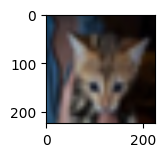

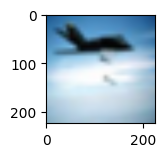

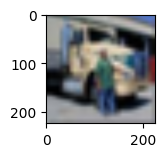

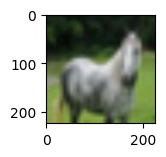

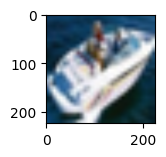

In [3]:
for i in range(5):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i])
    pyplot.show()

In [4]:
BATCH_SIZE = 64
input_shape = (224, 224, 3)
optimizer = Adam(learning_rate=0.001)
n_classes= 10

n_steps = X_train.shape[0] // BATCH_SIZE
n_val_steps = X_val.shape[0] // BATCH_SIZE
n_epochs = 100
model_input = Input(shape=input_shape)

# XCEPTION

In [5]:
def xception(model_input: Tensor, optimizer) -> training.Model:
    conv_base = Xception(include_top = False,
                weights = 'imagenet',
                input_shape = input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = Flatten()(conv_base.output)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs = conv_base.input, outputs= output_layer, name='xception_model')
    model.compile(optimizer=optimizer, 
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return model

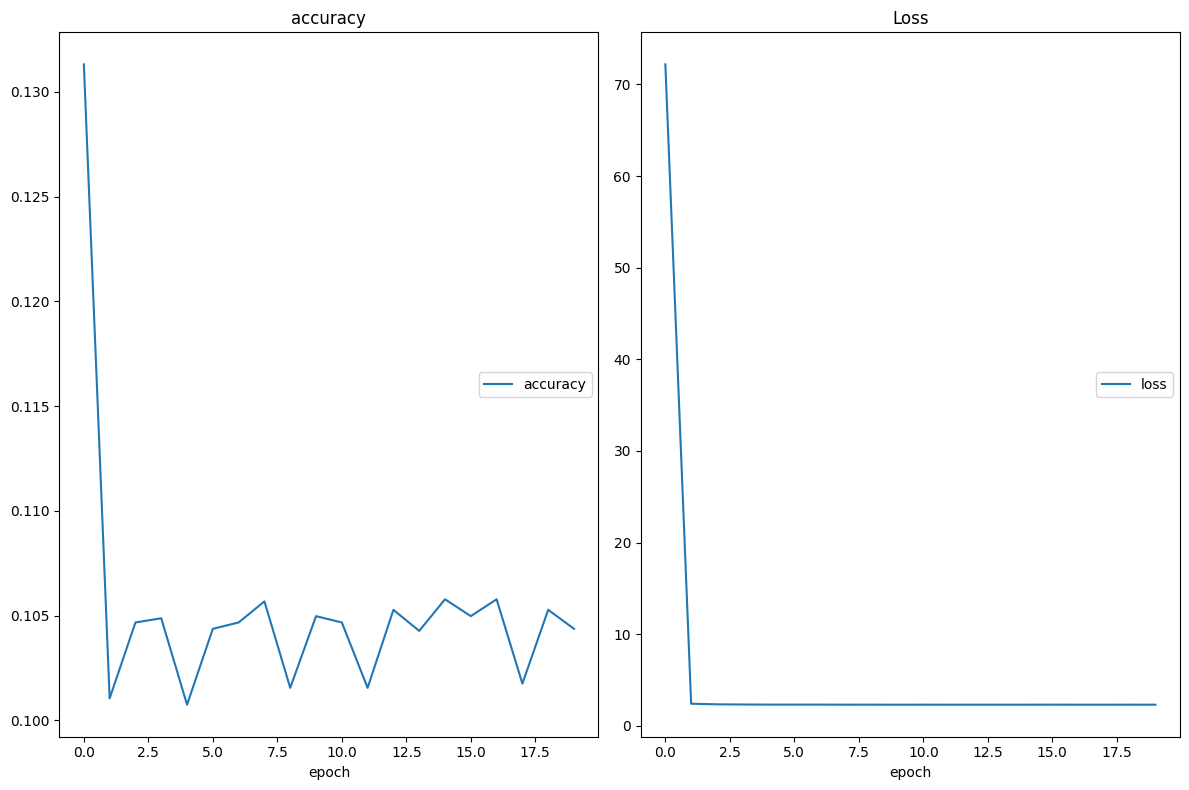

accuracy
	accuracy         	 (min:    0.101, max:    0.131, cur:    0.104)
Loss
	loss             	 (min:    2.304, max:   72.194, cur:    2.305)
156/156 [==============================] - 1106s 7s/step - loss: 2.3048 - accuracy: 0.1044


In [13]:
xception_model = xception(model_input, optimizer)
plot_loss_xception = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_xception = ModelCheckpoint(filepath='tl_model_cifar10_xception_medium.weights_.best.hdf5',
                                         monitor='loss',
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='loss',
                        patience=10,
                        restore_best_weights=True,
                        mode='min')

xception_history = xception_model.fit(X_train, y_train ,
        batch_size=BATCH_SIZE,
        epochs= n_epochs,
        shuffle= True,
        steps_per_epoch=n_steps,
        callbacks=[tl_checkpoint_xception, early_stop, plot_loss_xception],
        verbose=1)

32/32 [==============================] - 106s 3s/step


c:\Users\manel.benabid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\manel.benabid\AppData\Local\Temp\ipykernel_7840\2471500309.py:15: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis = 0)


{'accuracy': 0.091, 'balanced_acc': 0.091, 'precision': array([  nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.091,   nan,
         nan]), 'f1': array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.09528796,        nan,        nan]), 'sensitivity': 0.1, 'specificity': 0.9, 'g_mean': 0.30000000000000004}


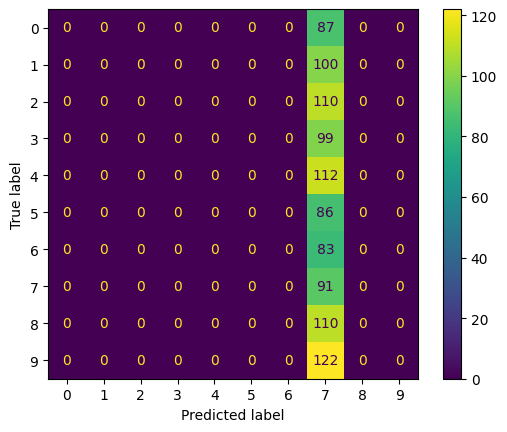

In [6]:
xception_model = xception(model_input, optimizer)
xception_model.load_weights("tl_model_cifar10_xception_medium.weights.best.hdf5")
y_prob = xception_model.predict(X_test)
y_pred = y_prob.argmax(axis=-1)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, jaccard_score, roc_auc_score

acc = accuracy_score(y_pred, y_test)
balanced_acc = balanced_accuracy_score(y_pred, y_test)

#auc = roc_auc_score(y_score = y_pred, y_true = y_test, multi_class="ovr")
precision = np.diag(cm) / np.sum(cm, axis = 0)
def sensitivity(y_true,y_pred):
        cm=confusion_matrix(y_true, y_pred)
        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
        Sensitivity = TP/(TP+FN)    
        return np.mean(Sensitivity)

sens = sensitivity(y_test, y_pred)
def specificity(y_true,y_pred):
        cm=confusion_matrix(y_true, y_pred)
        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
        Specificity = TN/(TN+FP)    
        return np.mean(Specificity)
specif= specificity(y_test, y_pred)

f1 = 2 * (precision * sens) / (precision + sens)

import math
g_mean = math.sqrt(sens * specif)

data = {
    "accuracy" : acc,
    "balanced_acc" : balanced_acc,
    "precision": precision,
    "f1": f1,
    "sensitivity": sens,
    "specificity": specif,
    "g_mean": g_mean
}
print(data)